In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from google.colab import files
import scipy.stats as ss
import itertools

In [ ]:
data = files.upload()

Saving data_final.csv to data_final (2).csv


# Exploring the Data

In [ ]:
df = pd.read_csv('data_final.csv')
df.head()

,Latin America,North America,Europe,ST attacked in routine environment (predictable events),ST threatened,open critic against attackers,attack during working hours,attack during day,unknown wherabouts of victim,attackers sighted during attack,responsibility claimed of attack by a group,how was victim attacked,was detailed intelligence required,killed in transit,did assassin break in,did victim have bodyguards,previous attempts on ST life,were there collateral casualties,fixated individual,lone actor,public attributes it to specific org,public attributes it to gov,year
0,0,0,1,1,0.0,0.0,0,0,0,0.0,1.0,shot,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2002
1,0,0,1,1,0.0,0.0,1,1,0,1.0,NaN,shot,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2018
2,0,0,1,1,1.0,1.0,0,0,0,0.0,0.0,shot,0,0.0,1,0,0.0,0,0.0,1.0,1,0,2019
3,0,1,0,1,0.0,0.0,1,0,0,1.0,0.0,shot,0,0.0,0,0,0.0,1,1.0,1.0,0,0,2008
4,0,1,0,1,0.0,1.0,1,0,0,1.0,0.0,shot,0,0.0,0,0,0.0,0,0.0,1.0,0,0,1990


In [ ]:
#Filling missing values

df.fillna(value = 0, inplace = True)
df.head()

,Latin America,North America,Europe,ST attacked in routine environment (predictable events),ST threatened,open critic against attackers,attack during working hours,attack during day,unknown wherabouts of victim,attackers sighted during attack,responsibility claimed of attack by a group,how was victim attacked,was detailed intelligence required,killed in transit,did assassin break in,did victim have bodyguards,previous attempts on ST life,were there collateral casualties,fixated individual,lone actor,public attributes it to specific org,public attributes it to gov,year
0,0,0,1,1,0.0,0.0,0,0,0,0.0,1.0,shot,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2002
1,0,0,1,1,0.0,0.0,1,1,0,1.0,0.0,shot,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2018
2,0,0,1,1,1.0,1.0,0,0,0,0.0,0.0,shot,0,0.0,1,0,0.0,0,0.0,1.0,1,0,2019
3,0,1,0,1,0.0,0.0,1,0,0,1.0,0.0,shot,0,0.0,0,0,0.0,1,1.0,1.0,0,0,2008
4,0,1,0,1,0.0,1.0,1,0,0,1.0,0.0,shot,0,0.0,0,0,0.0,0,0.0,1.0,0,0,1990


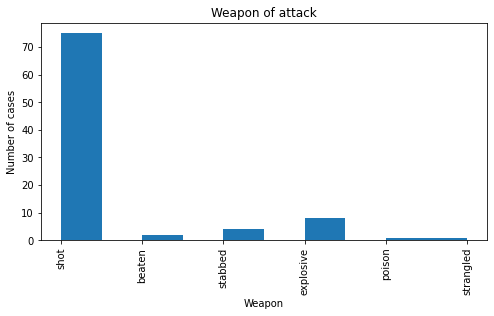

In [ ]:
df['how was victim attacked'].value_counts()

plt.figure(figsize = (8,4))
plt.title('Weapon of attack')
plt.hist(df['how was victim attacked'])
plt.xticks(rotation = 'vertical')
plt.xlabel('Weapon')
plt.ylabel('Number of cases')
plt.show()

In [1]:
print(df['Latin America'].value_counts())
print(df['North America'].value_counts())
print(df["how was victim attacked"].value_counts())

NameError: ignored

As we can observe there are 35 cases in Latin America, 17 cases in North America and 39 cases in Europe. Therefore we are going to reabalance the classes and artificially augment the latin america dataset by ...

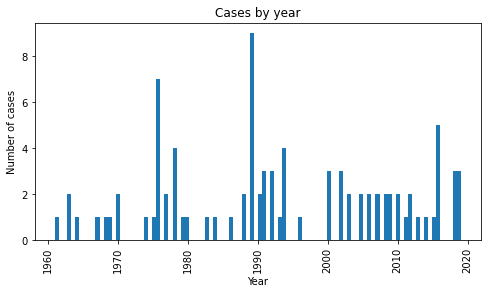

In [ ]:
plt.figure(figsize = (8,4))
plt.title('Cases by year')
plt.hist(df['year'], bins = 100)
plt.xticks(rotation = 'vertical')
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.show()

We can see that the cases in Latin America are more prominent after the late 80's. Next however let's turn how victim was attacked into a categorical variable before we can obtain results. We will do this by using a one hot label encoder from the pandas library.

In [ ]:
df = pd.get_dummies(df, columns=["how was victim attacked"])

#df.columns
df_new = df.rename(columns= {"ST attacked in routine environment (predictable events)": "routine env", "ST threatened": "threats", "open critic against attackers ": "open critic",
                    "attack during working hours ": "working hours", "attack during day": "during day", "unknown wherabouts of victim": "unknown whereabouts",
                    "attackers sighted during attack": "attackers sighted", "responsibility claimed of attack by a group":"responsibility claimed", 
                    "was detailed intelligence required":"detailed intelligence", "did assassin break in": "break in", "did victim have bodyguards":"bodyguards",
                    "previous attempts on ST life":"previous attempts", "were there collateral casualties":"collateral casualties", 
                    "public attributes it to specific org": "attributed org", "public attributes it to gov": "attributed gov", 
                    "how was victim attacked_beaten": "beaten", "how was victim attacked_explosive":"explosive", "how was victim attacked_poison": "poison",
                    "how was victim attacked_shot": "shot", "how was victim attacked_stabbed": "stabbed", "how was victim attacked_strangled": "strangled"})

df_new.head()

,Latin America,North America,Europe,routine env,threats,open critic,working hours,during day,unknown whereabouts,attackers sighted,responsibility claimed,detailed intelligence,killed in transit,break in,bodyguards,previous attempts,collateral casualties,fixated individual,lone actor,attributed org,attributed gov,year,beaten,explosive,poison,shot,stabbed,strangled
0,0,0,1,1,0.0,0.0,0,0,0,0.0,1.0,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2002,0,0,0,1,0,0
1,0,0,1,1,0.0,0.0,1,1,0,1.0,0.0,0,0.0,0,0,0.0,0,0.0,0.0,1,0,2018,0,0,0,1,0,0
2,0,0,1,1,1.0,1.0,0,0,0,0.0,0.0,0,0.0,1,0,0.0,0,0.0,1.0,1,0,2019,0,0,0,1,0,0
3,0,1,0,1,0.0,0.0,1,0,0,1.0,0.0,0,0.0,0,0,0.0,1,1.0,1.0,0,0,2008,0,0,0,1,0,0
4,0,1,0,1,0.0,1.0,1,0,0,1.0,0.0,0,0.0,0,0,0.0,0,0.0,1.0,0,0,1990,0,0,0,1,0,0


Next up we are going to be performing some nominal associations. Since all our data is categorical this will be done with Theils U and Cramers V. 

In [ ]:
df_new.columns

Index(['Latin America', 'North America', 'Europe', 'routine env', 'threats',
       'open critic', 'working hours', 'during day', 'unknown whereabouts',
       'attackers sighted', 'responsibility claimed', 'detailed intelligence',
       'killed in transit', 'break in', 'bodyguards', 'previous attempts',
       'collateral casualties', 'fixated individual', 'lone actor',
       'attributed org', 'attributed gov', 'year', 'beaten', 'explosive',
       'poison', 'shot', 'stabbed', 'strangled'],
      dtype='object')

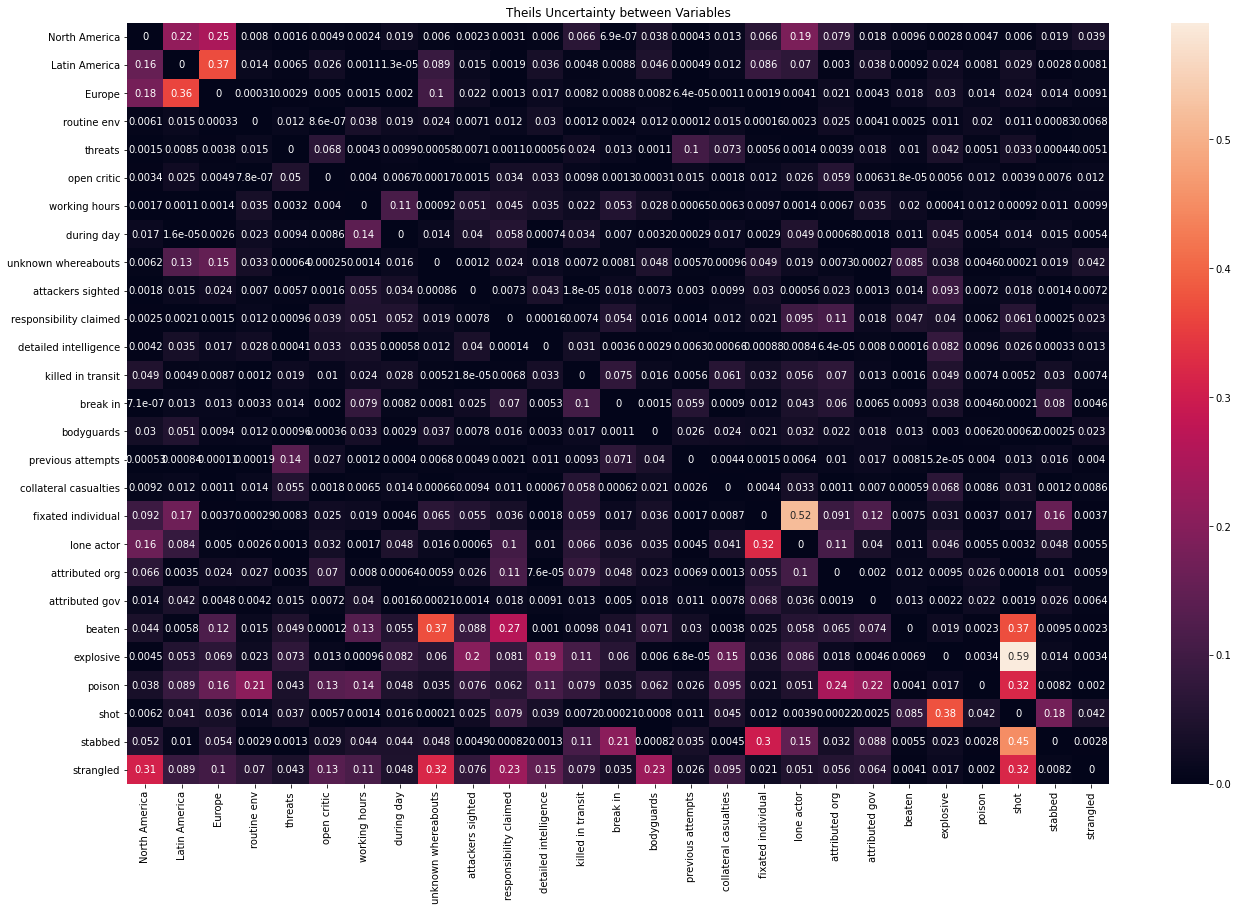

In [ ]:
import math
from collections import Counter 
import itertools as itertools
import seaborn as sns

def conditional_entropy(x, y, log_base: float = math.e):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples
        with missing values, or 'replace' to replace all missing values with
        the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when
        nan_strategy is set to 'replace'.
    log_base: float, default = e
        specifying base for calculating entropy. Default is base e.
    Returns:
    --------
    float
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy



def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

cols = ['North America', 'Latin America', 'Europe', 'routine env', 'threats',
       'open critic', 'working hours', 'during day', 'unknown whereabouts',
       'attackers sighted', 'responsibility claimed', 'detailed intelligence',
       'killed in transit', 'break in', 'bodyguards', 'previous attempts',
       'collateral casualties', 'fixated individual', 'lone actor',
       'attributed org', 'attributed gov', 'beaten', 'explosive',
       'poison', 'shot', 'stabbed', 'strangled']


corrM = np.zeros((len(cols),len(cols)))


# since theils u is not symmetric, we calculate it for each combination
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = theils_u(df_new[col1], df_new[col2])
    corrM[idx2, idx1] = theils_u(df_new[col2], df_new[col1])

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(22, 14))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Theils Uncertainty between Variables");


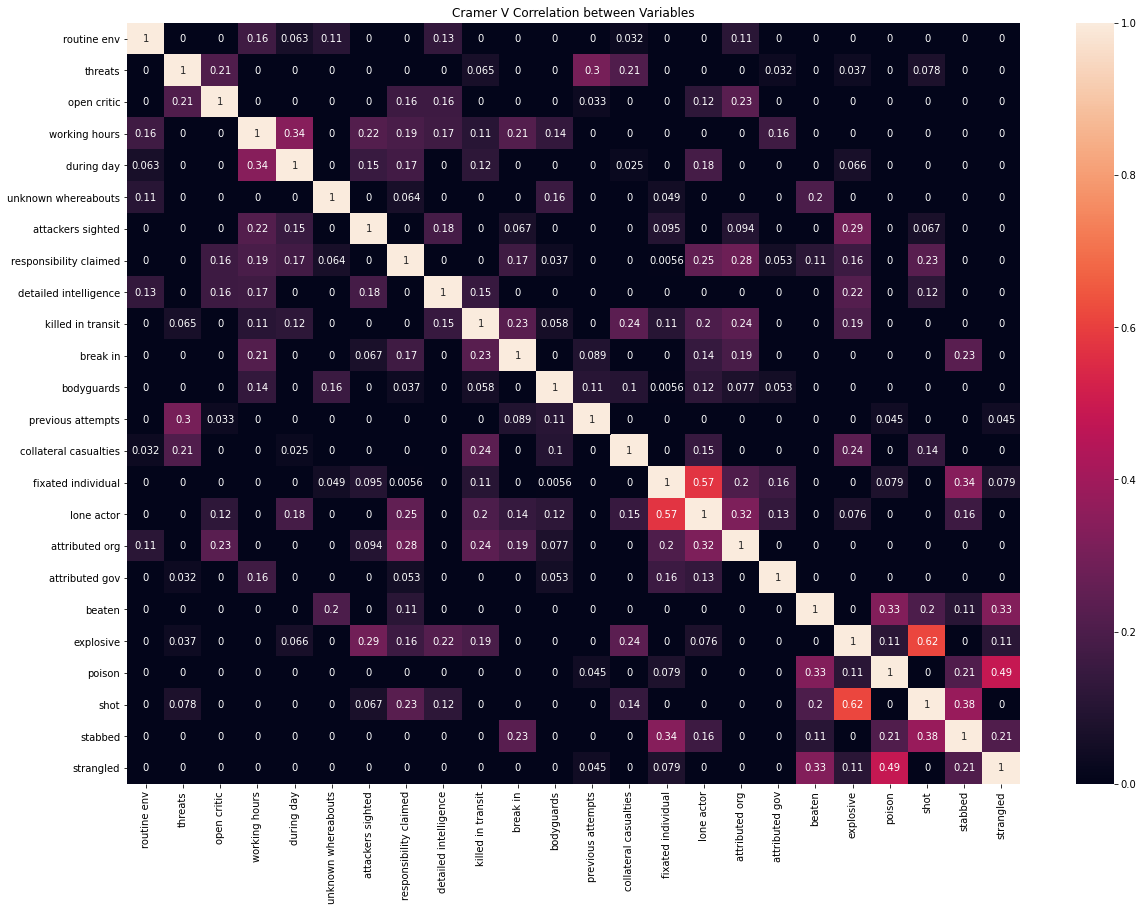

In [ ]:

def cramerV(x,y, bias_correction = True):
      confusion_matrix = pd.crosstab(x, y)
      chi2 = ss.chi2_contingency(confusion_matrix)[0]
      n = confusion_matrix.sum().sum()
      phi2 = chi2 / n
      r, k = confusion_matrix.shape
      if bias_correction:
          phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
          rcorr = r - ((r - 1) ** 2) / (n - 1)
          kcorr = k - ((k - 1) ** 2) / (n - 1)
          if min((kcorr - 1), (rcorr - 1)) == 0:
              warnings.warn(
                  "Unable to calculate Cramer's V using bias correction. Consider using bias_correction=False",
                  RuntimeWarning)
              return np.nan
          else:
              return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
      else:
          return np.sqrt(phi2 / min(k - 1, r - 1))

cols = ['North America', 'Latin America', 'Europe', 'routine env', 'threats',
       'open critic', 'working hours', 'during day', 'unknown whereabouts',
       'attackers sighted', 'responsibility claimed', 'detailed intelligence',
       'killed in transit', 'break in', 'bodyguards', 'previous attempts',
       'collateral casualties', 'fixated individual', 'lone actor',
       'attributed org', 'attributed gov', 'beaten', 'explosive',
       'poison', 'shot', 'stabbed', 'strangled']
corrM = np.ones((len(cols),len(cols)))


# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    #print(col1, col2)
    corrM[idx1, idx2] = cramerV(df_new[col1], df_new[col2])
    #corrM[idx2, idx1] = corrM[idx1, idx2]
    corrM[idx2, idx1] = cramerV(df_new[col2], df_new[col1])

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(22, 14))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");


#Chi Squared

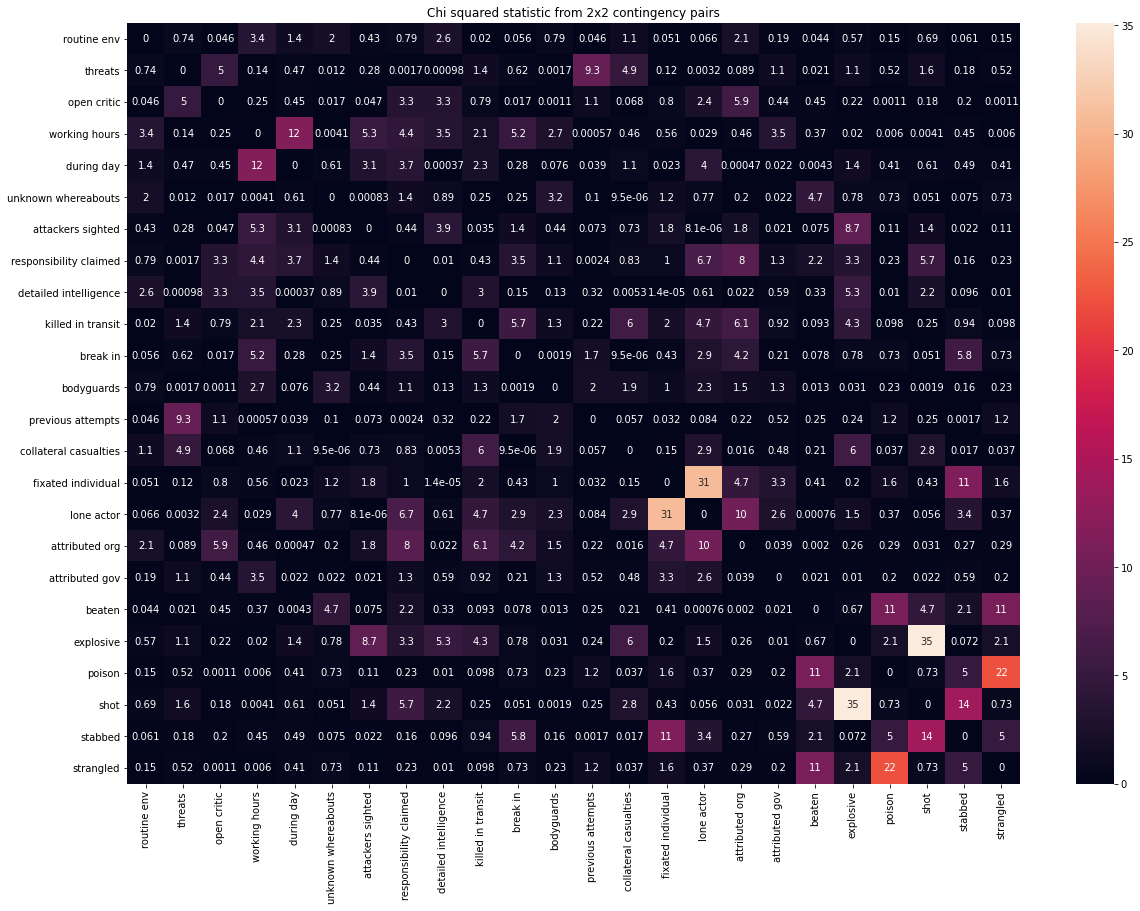

In [ ]:
from scipy.stats import chi2_contingency


corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    #print(col1, col2)
    corrM[idx1, idx2] = chi2_contingency(pd.crosstab(df_new[col1], df_new[col2]))[0]
    #corrM[idx2, idx1] = corrM[idx1, idx2]
    corrM[idx2, idx1] = chi2_contingency(pd.crosstab(df_new[col2], df_new[col1]))[0]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(20, 14))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Chi squared statistic from 2x2 contingency pairs");


In [ ]:

corrM = np.ones((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    #print(col1, col2)
    corrM[idx1, idx2] = chi2_contingency(pd.crosstab(df_new[col1], df_new[col2]))[1]
    #corrM[idx2, idx1] = corrM[idx1, idx2]
    corrM[idx2, idx1] = chi2_contingency(pd.crosstab(df_new[col2], df_new[col1]))[1]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(20, 14))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("P values (null hypothesis) for Chi squared statistic from 2x2 contingency pairs");

# Classification Algorithms to attempt a prediction of region based on features



## Unbalanced case with assumption that cases in North America are less prolific and therefore less likely to occur in general 

In [ ]:
#Splitting the data into training and validation sets

from sklearn.model_selection import train_test_split

Y = []

#creates new "region" column where 1,2,3 correspond to LA, NA, Europe 
for x,y in zip(df_new['Latin America'].values, df_new['North America'].values):
  if x == 1:
    Y.append(1)
  elif y == 1:
    Y.append(2)
  else:
    Y.append(3)

df_new['region'] = Y
X = df_new.drop(columns=['Latin America', 'North America', 'Europe', 'region', 'year'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

### Random Forest Classifier

In [ ]:
import sklearn.ensemble as ensemble


#instantiating the classifiers and fitting them to the training data
clf_balanced = ensemble.RandomForestClassifier()
clf_balanced.fit(X_train, y_train)

model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#X_train.columns

In [ ]:
#unbalanced case using gridsearchCV
#look at precision and recall when comparing balanced/unbalanced to assess overfitting.

#defining the hyperparamter grid using indication of values from for loops

from sklearn.model_selection import GridSearchCV, cross_val_score

n_estimators = np.arange(80,101)
max_features = np.arange(0,30)
param_grid = {
    #'max_depth': [3,4,5,6,7,8,9],
    'max_features': max_features,
    'n_estimators': n_estimators
}

#grid_search = GridSearchCV(estimator = clf_balanced, param_grid = param_grid, 
 #                         cv = None, n_jobs = -1, verbose = 2)
#grid_search.fit(X_train, y_train)
#grid_search.best_params_

In [ ]:
clf = ensemble.RandomForestClassifier(n_estimators = 84 , max_features = 3)
clf.fit(X_train, y_train)
accuracy = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
accuracy.mean()
print("Accuracy:%0.4f" % accuracy.mean())

In [ ]:
clf = ensemble.RandomForestClassifier(n_estimators = 84 , max_features = 3)
clf.fit(X_train, y_train)
accuracy = cross_val_score(clf, X_test, y_test, cv = 5, scoring = 'accuracy')
print("accuracy on test data:%0.4f" % accuracy.mean())

This model could in theory still be fine tuned and its performance could realistically increase in the single digit range. Let's see how the balanced case works out.

In [ ]:
y_pred= clf.predict(X_test)
print(y_pred, y_test)

In [ ]:
#evaluating performance
import sklearn.metrics as metrics
perf_rf = metrics.precision_recall_fscore_support(y_test, y_pred,average='macro',labels=[1, 2, 3]) #corresponds to LA, NA, EU vgood (in that order)
perf_rf

##Balanced case

In [ ]:
#Splitting the data into training and validation sets

from sklearn.model_selection import train_test_split
from sklearn.utils import resample


LA = df_new[df_new['region'] == 1]
NA = df_new[df_new['region'] == 2]
EU = df_new[df_new['region'] == 3]


NA_sampled = resample(NA, replace=True, n_samples=34).reset_index().drop(columns=['index'])

df_balanced = pd.concat([LA, NA_sampled, EU]).reset_index().drop(columns=['index'])

Y = []

#creates new "region" column where 1,2,3 correspond to LA, NA, Europe 
for x,y in zip(df_balanced['Latin America'].values, df_balanced['North America'].values):
  if x == 1:
    Y.append(1)
  elif y == 1:
    Y.append(2)
  else:
    Y.append(3)


X = df_balanced.drop(columns=['Latin America', 'North America', 'Europe', 'region', 'year'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [ ]:
import sklearn.ensemble as ensemble


#instantiating the classifiers and fitting them to the training data
clf_balanced = ensemble.RandomForestClassifier()
clf_balanced.fit(X_train, y_train)

model = ensemble.RandomForestClassifier()
model.fit(X_train, y_train)

# get importance
importance = model.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#X_train.columns

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

n_estimators = np.arange(80,101)
max_features = np.arange(0,30)
param_grid = {
    #'max_depth': [3,4,5,6,7,8,9],
    'max_features': max_features,
    'n_estimators': n_estimators
}

grid_search = GridSearchCV(estimator = clf_balanced, param_grid = param_grid, 
                          cv = None, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
clf = ensemble.RandomForestClassifier(n_estimators = 83 , max_features = 23)
clf.fit(X_train, y_train)
accuracy = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
print("Accuracy:%0.4f" % accuracy.mean())

In [ ]:
clf = ensemble.RandomForestClassifier(n_estimators = 83 , max_features = 23)
clf.fit(X_train, y_train)
accuracy = cross_val_score(clf, X_test, y_test, cv = 5, scoring = 'accuracy')
print("accuracy on test data:%0.4f" % accuracy.mean())

In [ ]:
y_pred= clf.predict(X_test)
print(y_pred, y_test)

We can see that it is not overfitting on Europe anymore and we also obtain a higher accuracy on the training set which is a good improvement.

In [ ]:
#evaluating performance
import sklearn.metrics as metrics
perf_rf = metrics.precision_recall_fscore_support(y_test, y_pred,average='macro',labels=[1, 2, 3]) #corresponds to LA, NA, EU vgood (in that order)
perf_rf

The precision, recall and f and support scores for the unbalanced case are: (0.4005012531328321, 0.36435786435786427, 0.3411605937921727, None) while the ones for the balanced case are shown above. Clearly the scores for the balanced case are much better. 